**Search over tokenization, window, and gap sizes.**

In [177]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [179]:
class Tokenizer:
    def __init__(self, collapse_mentions=False, collapse_digits=True):
        self.collapse_mentions = collapse_mentions
        self.collapse_digits = collapse_digits
        self.stopwords = stopwords
        
    def tokenize(self, text):
        punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
        text = text.lower()
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        if self.collapse_mentions:
            text = re.sub('@\S+', 'MENTION', text)
        else:
            text = re.sub('@\S+', 'MENTION_\1', text)
        text = re.sub('http\S+', 'THIS_IS_A_URL', text)
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
        if self.collapse_digits: # Numbers help!
            text = re.sub(r'[0-9]', '9', text) 
        toks = []
        for tok in text.split():
            tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
            tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
            for subtok in tok.split():
                if re.search('\w', subtok):
                    toks.append(subtok)
        return toks

In [180]:
DIR = '/data/2/protest'

In [181]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [182]:
def print_top_terms(clf, vec, n=100):
    feats = np.array(vec.get_feature_names())
    print('\n'.join(feats[np.argsort(clf.coef_[0])[::-1][:n]]))

In [183]:
def read_stopwords(path):
    return [s.strip().lower() for s in open(path)]

In [184]:
import os, io, json, codecs

def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

def iterate_instances(files, keywords, window_sz, gap_sz):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """
    for fname in files:
        user = filename2user(fname)
        lines = []
        #print(user)
        for i, line in enumerate(open(fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                pos_end = i+1
                neg_start = max(0, i - gap_sz - (2 * window_sz))
                neg_end = i - gap_sz - window_sz
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                yield (' '.join(lines[pos_start:pos_end]), 1, user)
                yield (' '.join(lines[neg_start:neg_end]), 0, user)
                break
            lines.append(js['text'])

In [185]:
def do_expt(all_files, collapse_mentions, collapse_digits, binary, ngram_range,
            min_df, use_idf, norm, window_sz, gap_sz):
    toker = Tokenizer(collapse_digits=collapse_digits, collapse_mentions=collapse_mentions)
    
    stopwords = set(read_stopwords(DIR + '/stopwords.txt'))    
    my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)
    #print('stoppp',stopwords,'\n')
    
    #print(my_stop_words)
    
    vectorizer = TfidfVectorizer(binary=binary, decode_error='ignore',ngram_range=ngram_range,
                                 max_df=1.0, min_df=min_df, use_idf=use_idf,
                                 tokenizer=toker.tokenize,
                                 norm=norm, stop_words=set(my_stop_words))
    y = []
    users = []
    iterator = iterate_instances(all_files, keywords, window_sz, gap_sz)
    X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
    y = np.array(y)
    print('X.shape=%s' % (str(X.shape)))
    cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
    accuracies = []
    model_mod = LogisticRegression(penalty='l2', C=1)
    for train_ind, test_ind in cv:
        model_mod.fit(X[train_ind],y[train_ind])   
        accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    model_mod.fit(X, y)
    print_top_terms(model_mod, vectorizer)
    return np.mean(accuracies)

In [ ]:
# This will run all combinations (hour or so to complete)
from itertools import product

collapse_mentions_opts = [False, True]
collapse_digits_opts = [False, True]
binary_opts = [True, False]
ngrams_opts = [(1, 2), (1, 1)]
min_df_opts = [2, 4]
use_idf_opts = [False, True]
norm_opts = [None, 'l2']
window_sz_opts = [50, 20, 10, 5, 1]
gap_opts = [100, 50, 20, 10, 1]

argnames = ['collapse_mentions', 'collapse_digits', 'binary', 'ngram_range',
            'min_df', 'use_idf', 'norm', 'window_sz', 'gap_sz']

option_iter = product(collapse_mentions_opts, collapse_digits_opts,
                      binary_opts, ngrams_opts, min_df_opts,
                      use_idf_opts, norm_opts, window_sz_opts,
                      gap_opts)
    
    
all_files = list(glob.glob(DIR + '/Timeline/*.txt'))
results = []
for options in option_iter:
    print('  '.join('%s=%s' % (name, opt) for name, opt in zip(argnames, options)))
    acc = do_expt(all_files, *options)
    print('acc=%g' % acc)
    print('')
    results.append((acc, options))


collapse_mentions=False  collapse_digits=False  binary=True  ngram_range=(1, 2)  min_df=2  use_idf=False  norm=None  window_sz=50  gap_sz=100
X.shape=(374, 16572)
saudade
12
saber
vamos
love
filho
HASHTAG_sabadodetremuranosdv
vem
ganha
campos
gt
hoje
THIS_IS_A_URL THIS_IS_A_URL
pai
pena
tinha
cuida
hoje dia
contigo
THIS_IS_A_URL hoje
pau
nós
paulo
visto
protesto
povo
THIS_IS_A_URL rt
podem
sono
aulas
faz
minutos
d
puta
palavra
fiz
acabei
fake
carro
amiga
frente
sai
agosto
te
rock
corrupção
lua
vergonha
pec
foi
sinal
MENTION_ gostei
manifestação
vi
casa
dilma
acha
vitória
gt MENTION_
rt
rt MENTION_
rt“MENTION_
silêncio
block
pt
eu fiz
HASHTAG_diadospais
povo vai
HASHTAG_globonews
ahahahahaha
MENTION_ ahahahahaha
querem
te amo
brasil MENTION_
tio
poderiam
olho
bandeira
sabe
partiu
consegui
quantos
t
pensei
amigas
vista
gol
veja
começou
viver
amo
toca
hj
MENTION_ sim
deve ser
levar
13
achei
chegar
amanhã
acc=0.4867

collapse_mentions=False  collapse_digits=False  binary=True  ngram

In [186]:
all_files = list(glob.glob(DIR + '/Timeline/*.txt'))
acc = do_expt(all_files, collapse_mentions=True, collapse_digits=False, binary=False, ngram_range=(1,2),
            min_df=2, use_idf=True, norm='l2', window_sz=20, gap_sz=100)

X.shape=(398, 7502)
HASHTAG_sabadodetremuranosdv
THIS_IS_A_URL rt
HASHTAG_sextadosdvcomsrtwitteiro
perfil
dilma
photo
volta
ontem
pt
sábado
chegando
cruzeiro
globo
brasil
sim
THIS_IS_A_URL acabou
THIS_IS_A_URL
falando
15
p
HASHTAG_debatenaglobo
tipo
corrupção
amiga
passa
bem
mudar
joga
preguiça
gol
parabéns
vamos
sábado 15
fora
presidente
HASHTAG_brasil
campos
gosta
HASHTAG_verdadessecretas
t
gols
photo THIS_IS_A_URL
status
metade
fred
deputado
vocês
casa
amor
panela
HASHTAG_luciananaglobo
HASHTAG_mudabrasil
MENTION te
cortina
posted photo
uso
THIS_IS_A_URL THIS_IS_A_URL
vergonha
HASHTAG_aécio45
publicar
de…
vez
te
marina
MENTION sim
calma
dom
manifestação
amanhã
propaganda
fifa
cabeça
nós
band
hoje
petrobras
HASHTAG_panelacohoje
vontade
pessoas
hahahaha
petistas
pe
feliz
lua
pão
sbt
contigo
HASHTAG_quintacomvalentinonosdv
desistir
protesto
MENTION amiga
bater
partido
whats
brother
MENTION MENTION
aula
THIS_IS_A_URL photo
rede
ato


In [187]:
print(acc)

0.588205128205


In [188]:
# See how this setting changes with gap size.
xx = []
yy = []
for gap in np.arange(150)[::10] + 10:
    acc = do_expt(all_files, collapse_mentions=False, collapse_digits=False, binary=False, ngram_range=(1,2),
                min_df=2, use_idf=True, norm='l2', window_sz=20, gap_sz=gap)
    xx.append(gap)
    yy.append(acc)
    #print(gap, acc)


X.shape=(510, 10051)
HASHTAG_sabadodetremuranosdv
HASHTAG_sextadosdvcomsrtwitteiro
MENTION_ MENTION_
volta
cruzeiro
HASHTAG_masterchefbr
1
manifestação
brasil
THIS_IS_A_URL
te amo
vocês
dilma
sim
tipo
nada
protesto
bem
faça
pt
video
r
brasileiros
perfil
diz
gosta
HASHTAG_aécio45
HASHTAG_luciananaglobo
adianta
corpo
HASHTAG_mudabrasil
40
stf
falando
2
preguiça
rede
manifestações
pmdb
uso
mentira
voltar
mudar
será
café
HASHTAG_globogolpista
photo THIS_IS_A_URL
amo
dom
vergonha
perde
sdv
bike
indo
dilma THIS_IS_A_URL
araújo
seria
mi
HASHTAG_verdadessecretas
político
caiu
2012
HASHTAG_calabocadilma
u
dirceu
situação
t
rua
compra
fora
pt MENTION_
presidente dilma
seção
líder
novamente
parabéns
vem
metade
sdv MENTION_
posted photo
HASHTAG_nofilter
projeto
porta
vender
lado
trocar
diferença
manha
dunas
THIS_IS_A_URL tempo
blog
gov
faltou
muitas
HASHTAG_quintacomvalentinonosdv
ótima
direita
time
HASHTAG_passelivre
saúde
X.shape=(490, 9608)
HASHTAG_sabadodetremuranosdv
HASHTAG_sextadosdvcom

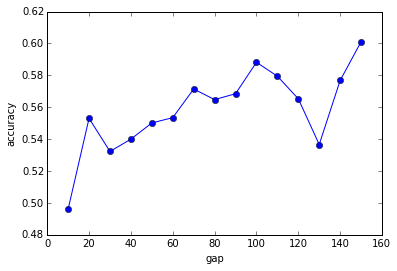

In [171]:
plt.figure()
plt.plot(xx, yy, 'bo-')
plt.xlabel('gap')
plt.ylabel('accuracy')
plt.show()

In [ ]:
def iterate_Testing_instances(path, keywords, negative_window,files_test):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """ 
    for fname in files_test:#glob.glob(path + '/*.txt'):
        user = filename2user(fname)
        
        lines = []
        var=None
        tweetlist=[]
        count=0
        for i, line in enumerate(open(path+fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= negative_window and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > negative_window and matches_keywords(js['text'], keywords):
                print(user)
                var=''
                mylines = lines[-100:]
                #for li, l in enumerate(lines[-100:][::-1]):  # just look at the most recent 50 tweets.
                for li, l in enumerate(mylines):
                    var = var + ' ' + l
                    # yield(var,user)
                    # yield(l,user)
                    yield (' '.join(mylines[max(0, li-10):li]), user)
                    count=count+1
                    if count==1500:
                        break
                #tweetlist=[]
                var=None
                break
            lines.append(js['text'])
            
y_test = []
users_test = []
negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.
files_test=[]
for _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos#list of all files in the directory
for f in arquivos:
    if f not in set(files_train):
        files_test.append(f)

print(len(arquivos))
print(len(set(files_test)))
print(len(files_train))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window, files_test)
X_ = vectorizer.transform(x[0] for x in iterator1 if not users_test.append(x[1]))
print('read %d instances into X matrix with shape %s' % (len(users_test), str(X_.shape)))
#print('label distribution=', Counter(y))
#y = np.array(y)
#users = np.array(users)
#print(type(y))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window,files_test)
iter1=list(iterator1)

In [ ]:
pred=model_mod.predict_proba(X_)

In [ ]:
X_.shape

In [ ]:
count =0
dictv = defaultdict(list)
for o in zip(iter1,pred):
    #print(o[0][1])
    dictv[o[0][1]].append(o[1][1])
print(len(dictv))

In [ ]:
%pylab inline
def is_interesting(vals):
    # if there's a significant jump between adjacent cells.
    for vi, vj in zip(vals[:-1], vals[1:]):
        if abs(vj - vi) > .00:
            return True
    return False

fig = plt.figure(figsize=(40,10))
for k,v in dictv.items():
    if is_interesting(dictv[k]):
        plt.plot(dictv[k])
print(len(dictv))

In [ ]:
import pickle 

output = open('predmodel.pkl', 'wb')
pickle.dump(pred, output)


In [ ]:
def plot_probs(dictv):
    %pylab inline
    fig = plt.figure(figsize=(40,10))
    
    for k, v in dictv.items():
        if is_interesting(v):
            i=1
            y=[]
            x=[]
            t = 1/len(dictv[k])
            for g in dictv[k]:
                y.append(g)
                x.append(i*t)
                i = i+1
            plt.xlabel('% of total tweets')
            plt.ylabel('Probability')
            plt.plot(x,y)

In [ ]:
plot_probs(dictv)

TypeError: 'module' object is not callable

In [93]:
from sklearn.feature_extraction import text
my_words = set(['my_stop_word_1','my_stop_word_2','hi','para','de','kkk'])
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
vectorizer = text.TfidfVectorizer(stop_words=set(my_stop_words),max_features=15000)
XX = vectorizer.fit_transform(["Hi, this is a test string my_stop_word_2 Hi kkk my_stop_word agora para de um"])
vectorizer.get_feature_names()
#[u'hi', u'my_stop_word', u'string', u'test']

['agora', 'my_stop_word', 'string', 'test', 'um']